In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import sys

from pathlib import Path
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
from functional import seq
import librosa
import seaborn as sns
sns.set_context("talk")

sys.path.append("..")
from sgs_utils.path_conf import speech_data_root_dir, loc_data_dir

speech_data_session_dir = speech_data_root_dir.joinpath("backup")
display(speech_data_session_dir)

pd.options.display.max_columns = None
pd.options.display.max_rows = None


PosixPath('/media/speech_webapp_cleaned/backup')

## Downloading all the data

In [3]:
# TODO update this with the latest link
# !wget --output-document="speech_data_webapp.zip" https://cloud.ilabt.imec.be/index.php/s/tB2enWmZCJskGmG/download
# !unzip speech_data_webapp.zip
# !mv speech_web_app /project_scratch/data/
# !rm speech_data_webapp.zip


The folder structure:

```txt
speech_webapp_cleaned
|-- backup
|   |-- 2020-11-26__12:40:00+01:00__4949e55b-daff-4255-9741-3206033a736b
|   |   |-- PiSCES
|   |   |-- Radboud
|   |   |-- marloes
|   |   `-- metadata.json
|   |-- 2020-11-26__14:29:00+01:00__8fb4d923-48d0-4704-9c32-235c61227f76
|   |   |-- PiSCES
|   |   |-- Radboud
|   |   |-- marloes
|   |   `-- metadata.json
|   |-- 2020-11-26__16:20:00+01:00__b8b6a8ee-2b45-41e1-9d93-3eacbc25fc34
|   |   |-- PiSCES
|   |   |-- Radboud
|   |   |-- marloes
|   |   `-- metadata.json
|   |-- ...
```

In [4]:
# look at the data
!ls -lh {speech_data_session_dir} | head -n 10

total 0
drwxr-xr-x 5 jonas jonas 71 Aug  3 23:16 2020-11-26__12:40:00+01:00__4949e55b-daff-4255-9741-3206033a736b
drwxr-xr-x 5 jonas jonas 71 Jun 27 07:19 2020-11-26__14:29:00+01:00__8fb4d923-48d0-4704-9c32-235c61227f76
drwxr-xr-x 5 jonas jonas 71 Jun 27 07:19 2020-11-26__16:20:00+01:00__b8b6a8ee-2b45-41e1-9d93-3eacbc25fc34
drwxr-xr-x 5 jonas jonas 71 Jun 27 07:20 2020-11-26__18:50:00+01:00__33583a00-841f-4bef-b711-a8fe58c14476
drwxr-xr-x 5 jonas jonas 71 Jun 27 07:20 2020-11-27__08:06:00+01:00__f46c79e9-7c35-4bd4-b384-078aeae84af7
drwxr-xr-x 5 jonas jonas 71 Jun 27 07:20 2020-11-27__08:26:00+01:00__9223720f-1a2a-4811-84a1-a421646f63a0
drwxr-xr-x 5 jonas jonas 71 Jun 27 07:21 2020-11-27__12:06:00+01:00__716dc108-5588-49ed-bf3c-04fb87212e2b
drwxr-xr-x 5 jonas jonas 71 Jun 27 07:21 2020-11-27__12:24:00+01:00__99d276a0-83fe-4d47-949e-481dc67b2688
drwxr-xr-x 5 jonas jonas 71 Jun 27 07:22 2020-11-27__16:37:00+01:00__b55d08fb-30f3-499f-8cf4-f0f44321f1a9
ls: write error: Broken pipe


In [5]:
# This snippet summarizes the dir-names of the various folders
# within `speech_data_session_dir`
dir_list = []
for folder in speech_data_session_dir.iterdir():
    if not folder.is_dir():
        continue
    dir_list.extend(
        seq(folder.iterdir())
        .filter(lambda x: x.is_dir())
        .map(lambda x: x.name)
        .to_list()
    )
print(pd.Series(dir_list).value_counts())
del dir_list, folder


marloes    89
PiSCES     89
Radboud    89
dtype: int64


## Parsing the `metadata.json` file

The `metadata.json` file resides within each user ID folder and withholds the users's 
metadata such as:
* gender
* age
* education
* used mic
* etc ...

In [6]:
metadata_dict_list = []

# creating alldata.csv
for folder in speech_data_session_dir.iterdir():
    if not folder.is_dir():
        continue

    metadata = folder.joinpath("metadata.json")
    if not metadata.is_file():
        continue

    with open(metadata, "r") as f:
        metadata_dict = json.load(f)
    metadata_dict["ID"] = folder.name.split("__")[-1]

    metadata_dict["Marloes"] = len(list(folder.joinpath("marloes").glob("*.wav")))
    metadata_dict["PiSCES"] = len(list(folder.joinpath("PiSCES").glob("*.wav")))
    metadata_dict["Radboud"] = len(list(folder.joinpath("Radboud").glob("*.wav")))

    metadata_dict_list.append(metadata_dict)

df_metadata = pd.DataFrame(metadata_dict_list)

# convert the columns to the correct data format
df_metadata["age"] = df_metadata["age"].astype(int)
df_metadata[["sex", "device", "education"]] = df_metadata[
    ["sex", "device", "education"]
].astype("category")
df_metadata["timestamp"] = pd.to_datetime(
    df_metadata.timestamp, utc=True
).dt.tz_convert("Europe/Brussels")

del folder, metadata_dict, metadata_dict_list, f, metadata
df_metadata.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89 entries, 0 to 88
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype                          
---  ------          --------------  -----                          
 0   age             89 non-null     int64                          
 1   education       89 non-null     category                       
 2   sex             89 non-null     category                       
 3   timestamp       89 non-null     datetime64[ns, Europe/Brussels]
 4   ID              89 non-null     object                         
 5   Marloes         89 non-null     int64                          
 6   PiSCES          89 non-null     int64                          
 7   Radboud         89 non-null     int64                          
 8   device          75 non-null     category                       
 9   prolific_token  54 non-null     object                         
dtypes: category(3), datetime64[ns, Europe/Brussels](1), int64(4), ob

## Analyzing the metadata

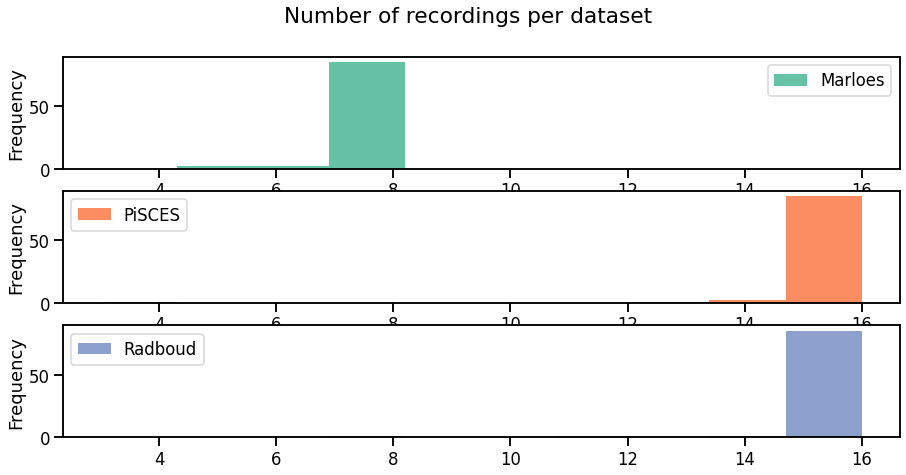

In [7]:
df_metadata[["Marloes", "PiSCES", "Radboud"]].plot(
    subplots=True,
    kind="hist",
    figsize=(15, 7),
    sharex=False,
    color=sns.color_palette("Set2"),
    title='Number of recordings per dataset',
);


In [8]:
# NOTE: as for now we do not filter
# TODO -> reconsider this
df_metadata_relevant = (
    # df_metadata[
        # ~(
        #     (df_metadata.Marloes >= 6)
        #     & (df_metadata.Radboud >= 14)
        #     & (df_metadata.PiSCES >= 14)
        # )
    # ]
    df_metadata
    .reset_index(drop=True)
    .copy()
)

df_metadata_relevant[
    ["age", "sex", "device", "Marloes", "PiSCES", "Radboud"]
].describe()


,age,Marloes,PiSCES,Radboud
count,89.000000,89.000000,89.000000,89.000000
mean,27.528090,6.932584,14.831461,14.865169
std,6.629976,0.330212,1.298915,0.906931
min,19.000000,5.000000,3.000000,7.000000
25%,23.000000,7.000000,15.000000,15.000000
50%,26.000000,7.000000,15.000000,15.000000
75%,30.000000,7.000000,15.000000,15.000000
max,53.000000,7.000000,16.000000,15.000000


female    45
male      43
other      1
Name: sex, dtype: int64

----------------------------------------


pc-mic       36
headset      17
earphones    16
other         6
Name: device, dtype: int64

----------------------------------------


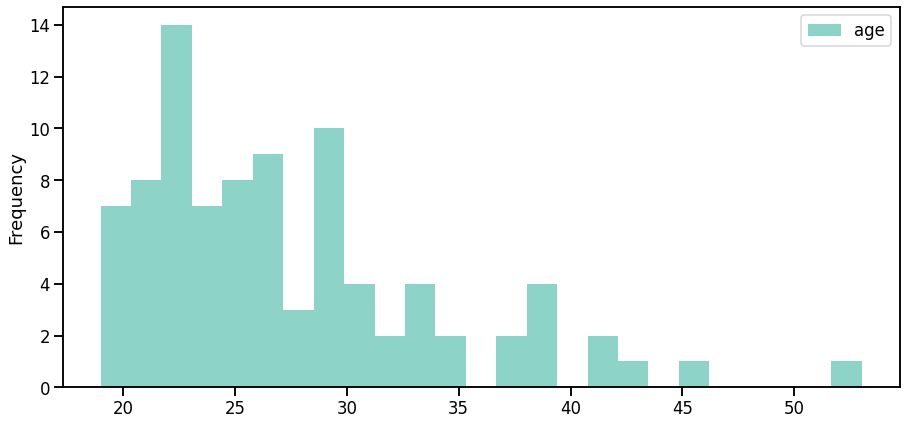

In [9]:
display(df_metadata_relevant.sex.value_counts())
print("-" * 40)
display(df_metadata_relevant.device.value_counts())
print("-" * 40)
df_metadata_relevant.education.value_counts()

# Also plot the distributions
df_metadata_relevant[["age"]].plot(
    kind="hist",
    subplots=True,
    sharex=False,
    figsize=(15, 7),
    backend="matplotlib",
    color=sns.color_palette("Set3"),
    bins=25,
);


In [10]:
df_metadata_relevant.to_parquet(loc_data_dir.joinpath("metadata_rel_ids.parquet"))


## Extracting recording (meta)data from each session

In [11]:
session_dict_list = []


# Iterate over each session
for folder in speech_data_session_dir.iterdir():
    if not folder.is_dir():
        continue

    def parse_pic_name_ts(db_folder, pic_name, time_str, sep="__") -> dict:
        """Get the arousal valence json for the corresponding description"""
        # what can we save from the wav file?
        json_f = sep.join([pic_name, time_str]) + ".json"
        json_f = db_folder.joinpath(json_f)
        if not json_f.is_file():
            # print('json_f does not exist')
            return {}

        with open(json_f, "r") as f:
            return json.load(f)

    def get_wav_json_mapping(db_folder: Path) -> dict:
        """Get the mapping from wav file to corresponding json (arousal/valence) file"""
        # parse the wav files to construct a dataframe
        wav_list = list(db_folder.glob("*.wav"))
        df_db_wav = pd.Series(
            seq(wav_list).map(lambda x: x.name), name="wav_files", dtype="str"
        ).to_frame()
        df_db_wav["wav_timestamp"] = seq(wav_list).map(
            lambda wav_file: pd.Timestamp(
                wav_file.stat().st_mtime, unit="s", tz="Europe/Brussels"
            )
        ).to_list()
        df_db_wav = df_db_wav.sort_values(by="wav_timestamp")

        # parse the json files to construct a dataframe
        json_list = list(db_folder.glob("*.json"))
        df_db_json = pd.Series(
            seq(json_list).map(lambda x: x.name), name="json_files", dtype="str"
        ).to_frame()
        df_db_json["json_timestamp"] = seq(json_list).map(
            lambda json_file: pd.Timestamp(
                json_file.stat().st_mtime, unit="s", tz="Europe/Brussels"
            )
        ).to_list()
        df_db_json = df_db_json.sort_values(by="json_timestamp")

        json_wav_mapping = pd.merge_asof(
            left=df_db_wav,
            right=df_db_json,
            left_on="wav_timestamp",
            right_on="json_timestamp",
            tolerance=pd.Timedelta(minutes=5),
            # A "forward" search selects the first row in the right DataFrame whose 'on' key
            # is greater than or equal to the left's key.
            direction="forward",
        )

        json_wav_mapping = json_wav_mapping.dropna(how="any", axis=0)
        json_wav_mapping = json_wav_mapping[
            ~(
                json_wav_mapping["wav_timestamp"]
                < json_wav_mapping["json_timestamp"].shift(1)
            )
        ].reset_index(drop=True)

        # Asserts to check that the merge is performed correctly
        assert all(
            (
                json_wav_mapping["json_timestamp"].shift(1)
                < json_wav_mapping["wav_timestamp"]
            ).values[1:]
        )
        wav_json_mapping_dict = (
            json_wav_mapping[["json_files", "wav_files"]]
            .set_index("wav_files")
            .to_dict()["json_files"]
        )
        return wav_json_mapping_dict

    # Iterate over each database folder
    for db_folder in [folder.joinpath(x) for x in ["marloes", "Radboud", "PiSCES"]]:
        wav_json_mapping_dict = get_wav_json_mapping(db_folder)

        for wav_file in db_folder.glob("*.wav"):
            pic_name, time_str = wav_file.name.split("__")
            metadata_dict = parse_pic_name_ts(db_folder, pic_name, time_str)
            metadata_dict["pic_name"] = pic_name
            metadata_dict["time_str"] = time_str.split(".")[0]
            metadata_dict["wav_size"] = wav_file.stat().st_size
            data, sample_rate = librosa.load(path=wav_file, sr=None)
            metadata_dict["wav_sample_rate"] = sample_rate
            metadata_dict["wav_duration_s"] = round(data.shape[0] / sample_rate, 2)
            ts = pd.Timestamp(wav_file.stat().st_mtime, unit="s", tz="Europe/Brussels")
            metadata_dict["wav_timestamp"] = ts + ts.utcoffset()
            metadata_dict["ID"] = db_folder.parent.name.split("__")[-1]
            metadata_dict["DB"] = db_folder.name

            # also read the json file to fetch the arousal and valence values
            if wav_file.name in wav_json_mapping_dict:
                with open(
                    db_folder.joinpath(wav_json_mapping_dict[wav_file.name]), "r"
                ) as f:
                    json_dct = json.load(f)
                    metadata_dict["arousal"] = int(json_dct.get("arousal"))
                    metadata_dict["valence"] = int(json_dct.get("valence"))

            session_dict_list.append(metadata_dict)

df_session = pd.DataFrame(session_dict_list)

# Sanity check - to see whether the wav_time_obj corresponds with the time_str
# there must be < 10 minutes of difference between the two
assert all(
    (
        df_session.apply(
            lambda r: r.wav_timestamp.replace(
                **dict(
                    zip(
                        ["hour", "minute", "second"],
                        list(map(int, r.time_str.split(":"))),
                    )
                )
            ),
            axis=1,
        )
        - df_session.wav_timestamp
    ).abs()
    < pd.Timedelta(minutes=10)
)


del folder, db_folder, wav_file, ts, metadata_dict, session_dict_list, time_str, f
del parse_pic_name_ts, pic_name, wav_json_mapping_dict, json_dct, data, sample_rate

display(df_session.sample(3))

print("-" * 88)

df_session_tot = df_metadata_relevant.merge(
    df_session, how="left", left_on="ID", right_on="ID"
)
display(df_session_tot.sample(3))

del df_session


,pic_name,time_str,wav_size,wav_sample_rate,wav_duration_s,wav_timestamp,ID,DB,arousal,valence
1758,Rafd090_33_Caucasian_male_neutral_frontal,14:49:36,9281580,48000,96.68,2022-06-27 14:49:38+02:00,28d01050-e4e0-4115-a5e9-09c8cb917fb0,Radboud,45,55
819,marloes,22:04:10,2719788,48000,28.33,2020-12-04 22:05:40+01:00,e0c00b33-2151-4bcf-98b8-82f7701fccea,marloes,60,57
654,Rafd090_61_Caucasian_female_neutral_frontal,17:44:41,3981356,48000,41.47,2020-12-01 17:44:42+01:00,f57eb3a1-bc73-4fb8-9c40-8a31a6b67e34,Radboud,29,44


----------------------------------------------------------------------------------------


,age,education,sex,timestamp,ID,Marloes,PiSCES,Radboud,device,prolific_token,pic_name,time_str,wav_size,wav_sample_rate,wav_duration_s,wav_timestamp,DB,arousal,valence
708,26,unif,male,2020-12-04 14:28:08.555577+01:00,94025116-4e19-4718-9e4e-c9f5af205b4c,7,15,15,pc-mic,NaN,marloes,15:00:06,2547756,48000,26.54,2020-12-04 15:00:08+01:00,marloes,12,18
0,20,so,male,2020-11-26 12:40:36.592925+01:00,4949e55b-daff-4255-9741-3206033a736b,7,15,15,NaN,NaN,marloes,13:01:11,2228268,44100,25.26,2020-11-26 13:01:12+01:00,marloes,58,44
889,29,unif,female,2020-12-07 11:30:48.886529+01:00,f88413cc-ace9-4c88-852e-75c59a84e46a,7,15,15,pc-mic,NaN,Picture 88,11:44:49,2818092,48000,29.35,2020-12-07 11:44:54+01:00,PiSCES,32,62


### Add the `DB_no` and `session_no` column

In [12]:
import numpy as np

# This is a simplified testcase to see whether the applied logic will work
test_arr = [1, 10, 3, 5, 2, 8, 100, 12, 200]
print(np.array(test_arr))
print(np.argsort(test_arr))
print(1 + np.argsort(np.argsort(test_arr)))


[  1  10   3   5   2   8 100  12 200]
[0 4 2 3 5 1 7 6 8]
[1 6 3 4 2 5 8 7 9]


In [13]:
df_session_tot["DB_no"] = df_session_tot.groupby(["ID", "DB"])["wav_timestamp"].apply(
    lambda s: 1 + s.argsort().argsort()
)
df_session_tot["session_no"] = df_session_tot.groupby(["ID"])["wav_timestamp"].apply(
    lambda s: 1 + s.argsort().argsort()
)

df_session_tot["pic_no"] = None
pic_mask = df_session_tot.DB != "marloes"
df_session_tot.loc[pic_mask, "pic_no"] = (
    df_session_tot[pic_mask]
    .groupby(["ID"])
    .wav_timestamp.apply(lambda s: 1 + s.argsort().argsort())
)


## Duration based visualizations

<AxesSubplot:ylabel='Frequency'>

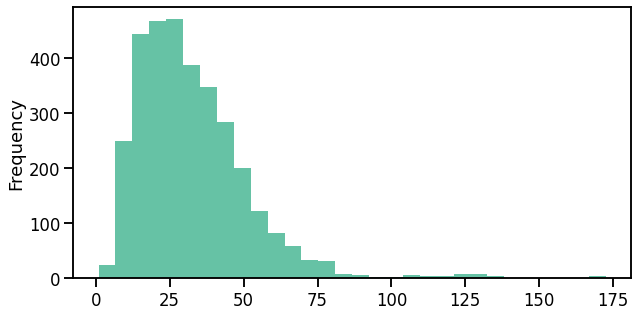

In [14]:
(
    (df_session_tot.wav_timestamp - df_session_tot.timestamp).dt.total_seconds() / 60
).plot.hist(figsize=(10, 5), bins=30, color=sns.color_palette('Set2', 2))


<AxesSubplot:xlabel='wav_duration_s', ylabel='Count'>

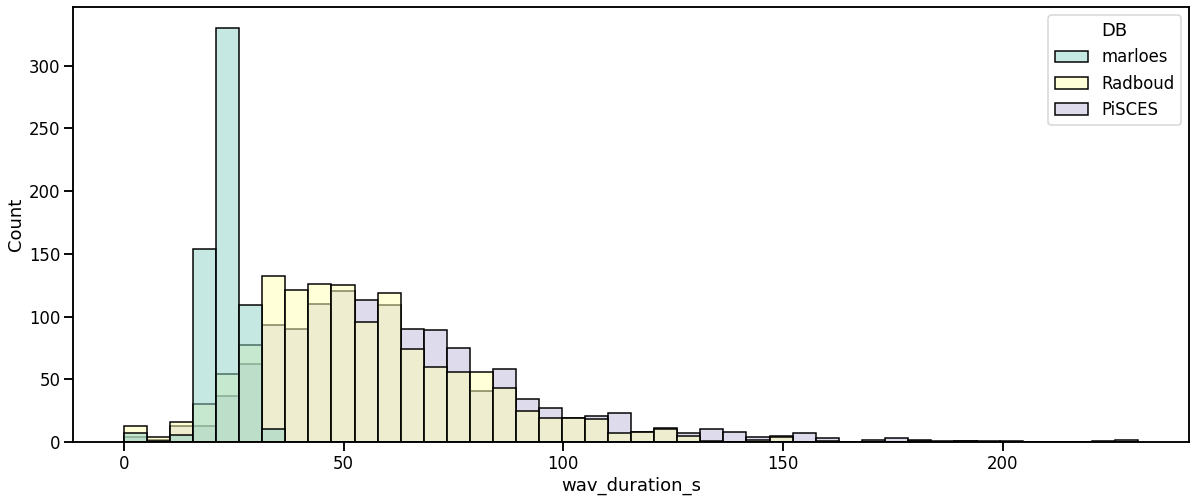

In [15]:
fig, ax = plt.subplots(figsize=(20, 8))
sns.set_context('talk')
sns.histplot(
    data=df_session_tot,
    hue="DB",
    x="wav_duration_s",
    palette="Set3",
    ax=ax,
)


## Analyzing the sample rate

<AxesSubplot:>

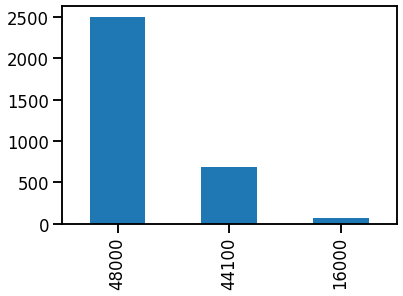

In [16]:
df_session_tot.wav_sample_rate.value_counts().plot.bar()

### Investigating the file duration

In [17]:
df_session_tot[
    (df_session_tot.wav_size > 400)
    & (df_session_tot.wav_duration_s < 20)
    & (df_session_tot.DB != "marloes")
].groupby(["ID", "timestamp", "prolific_token", "DB"]).size().to_frame()


0
ID                                   timestamp                        prolific_token           DB         
9a725424-aafb-4d9b-8be7-acad80a46614 2022-07-27 14:55:01.266930+02:00 60fe5f65bf40c582873fefc2 Radboud   4
a2dbee10-fc31-42ec-89f8-9b4e5fa74b7f 2022-06-27 22:18:01.896264+02:00 5f2be3f5d81eaf0009520f8b PiSCES   14
                                                                                               Radboud  15
c30db4c2-a62a-4d69-8f1b-893a1f4b8c9d 2022-07-16 21:49:33.730743+02:00 5e360d610d43625c7da0a09d Radboud   1
e61cd702-cd5f-4258-b4ef-57665e20803c 2022-06-29 14:23:23.366587+02:00 5b0c1fdebd9c3100015641ae PiSCES    1

### Filtering events

In [18]:
df_session_tot.sample(3)


,age,education,sex,timestamp,ID,Marloes,PiSCES,Radboud,device,prolific_token,pic_name,time_str,wav_size,wav_sample_rate,wav_duration_s,wav_timestamp,DB,arousal,valence,DB_no,session_no,pic_no
763,29,unif,female,2020-12-04 17:54:30.318797+01:00,9c44a144-8722-4d83-9bc7-f3c1189c5b82,7,15,15,pc-mic,NaN,Rafd090_57_Caucasian_female_neutral_frontal,18:24:47,3891244,48000,40.53,2020-12-04 18:24:50+01:00,Radboud,54,37,11,27,22
2291,23,unif,female,2022-06-29 18:40:00.899255+02:00,30e98ab0-b9c4-4dfe-a00f-1634bef1c426,7,15,15,pc-mic,6106e5fa2185277b70b2dc45,Picture 80,18:58:58,2416684,48000,25.17,2022-06-29 18:58:56+02:00,PiSCES,73,61,8,18,15
2320,26,unif,male,2022-06-29 18:46:27.440049+02:00,1bf0c688-1152-4489-8af0-b2419b18f2bf,7,15,15,headset,n.a.,Rafd090_61_Caucasian_female_neutral_frontal,19:18:01,770092,16000,24.06,2022-06-29 19:18:02+02:00,Radboud,45,46,13,32,26


In [19]:
# We store the pic_count (number of times the user described the picutre) to use a a future filter
df_session_tot["pic_count"] = (
    df_session_tot[df_session_tot.DB != "marloes"]
    .groupby(["ID", "pic_name"])["pic_name"]
    .transform("count")
)

out = df_session_tot[df_session_tot.DB != "marloes"].groupby(["ID", "pic_name"]).size()
display(out[out > 1])
del out


ID                                    pic_name                                   
9223720f-1a2a-4811-84a1-a421646f63a0  Picture 59                                     2
e0c00b33-2151-4bcf-98b8-82f7701fccea  Picture 81                                     2
                                      Rafd090_32_Caucasian_female_neutral_frontal    2
dtype: int64

In [24]:
ids_to_skip = [
    "a97a84b6-7a66-461f-810e-b54bac686f64",  # Test run mitchel (a lot of short sessions)
    "a2dbee10-fc31-42ec-89f8-9b4e5fa74b7f",  # Too much short sessions
    "87eafb16-0598-4340-9564-8e630acf85d6",  # This prolific users does not want to be included into the data analysis
    # TODO -> we do not need to throw thes all away; but for sake of simplicity we do now
    # "716dc108-5588-49ed-bf3c-04fb87212e2b",  # Got Picture 59 twice
    # "9223720f-1a2a-4811-84a1-a421646f63a0",  # Got Picture 59 twice
    # "e0c00b33-2151-4bcf-98b8-82f7701fccea",  # Got Picture 81 and Rafd090_32_Caucasian_female_neutral_frontal twice
]

df_session_tot_cleaned = df_session_tot[
    (~df_session_tot.ID.isin(ids_to_skip)) & (df_session_tot.wav_size > 400)
].copy()
df_session_tot_cleaned = df_session_tot_cleaned.sort_values(
    by=["ID", "wav_timestamp"], ignore_index=True
)
print(df_session_tot.shape)
display(df_session_tot_cleaned.shape)


(3260, 23)


(3199, 23)

In [25]:
# custom parsing
display(
    df_session_tot_cleaned[
        df_session_tot_cleaned.ID == "f57eb3a1-bc73-4fb8-9c40-8a31a6b67e34"
    ]
    .sort_values(by="wav_timestamp")[["session_no", "wav_timestamp", "DB"]]
    .iloc[:10]
)
# this user starts with pisces and has a total of 6 marloes instead of 7
# for some reason, the first marloes was not stored -> adjust the session_no and DB_no
df_session_tot_cleaned.loc[
    df_session_tot_cleaned.ID == "f57eb3a1-bc73-4fb8-9c40-8a31a6b67e34", "session_no"
] += 1
df_session_tot_cleaned.loc[
    (df_session_tot_cleaned.ID == ("f57eb3a1-bc73-4fb8-9c40-8a31a6b67e34"))
    & (df_session_tot_cleaned.DB == "marloes"),
    "DB_no",
] += 1
display(
    df_session_tot_cleaned[
        df_session_tot_cleaned.ID == "f57eb3a1-bc73-4fb8-9c40-8a31a6b67e34"
    ]
    .sort_values(by="wav_timestamp")[["session_no", "wav_timestamp", "DB"]]
    .iloc[:10]
)


,session_no,wav_timestamp,DB
3089,1,2020-12-01 17:29:06+01:00,PiSCES
3090,2,2020-12-01 17:29:42+01:00,Radboud
3091,3,2020-12-01 17:30:44+01:00,PiSCES
3092,4,2020-12-01 17:31:22+01:00,Radboud
3093,5,2020-12-01 17:32:34+01:00,PiSCES
3094,6,2020-12-01 17:33:10+01:00,marloes
3095,7,2020-12-01 17:33:52+01:00,Radboud
3096,8,2020-12-01 17:34:44+01:00,PiSCES
3097,9,2020-12-01 17:36:02+01:00,Radboud
3098,10,2020-12-01 17:36:40+01:00,PiSCES


,session_no,wav_timestamp,DB
3089,2,2020-12-01 17:29:06+01:00,PiSCES
3090,3,2020-12-01 17:29:42+01:00,Radboud
3091,4,2020-12-01 17:30:44+01:00,PiSCES
3092,5,2020-12-01 17:31:22+01:00,Radboud
3093,6,2020-12-01 17:32:34+01:00,PiSCES
3094,7,2020-12-01 17:33:10+01:00,marloes
3095,8,2020-12-01 17:33:52+01:00,Radboud
3096,9,2020-12-01 17:34:44+01:00,PiSCES
3097,10,2020-12-01 17:36:02+01:00,Radboud
3098,11,2020-12-01 17:36:40+01:00,PiSCES


In [28]:
df_session_tot_cleaned[
    (df_session_tot_cleaned.wav_duration_s < 18)
    & (df_session_tot_cleaned.DB != "marloes")
].groupby(["ID", "timestamp", "DB"]).size().to_frame()


0
ID                                   timestamp                        DB        
0bae55f8-2aab-4c7b-917f-7f0c3e627e5f 2020-11-27 20:02:22.592132+01:00 Radboud  2
29fb88a7-d9de-428b-9905-88d1f05a6154 2020-12-09 15:55:02.026184+01:00 Radboud  7
3bdd33ef-9671-4a3e-b152-eff41ef674e8 2020-12-01 10:39:34.523391+01:00 Radboud  1
5ef38e39-8146-4cf5-b365-43a08eac9905 2020-11-29 16:26:03.291969+01:00 PiSCES   3
                                                                      Radboud  7
7e62dc42-e811-4674-ba8b-302850dd84e5 2020-11-30 13:47:57.876901+01:00 PiSCES   1
9a725424-aafb-4d9b-8be7-acad80a46614 2022-07-27 14:55:01.266930+02:00 Radboud  4
c30db4c2-a62a-4d69-8f1b-893a1f4b8c9d 2022-07-16 21:49:33.730743+02:00 Radboud  1
f46c79e9-7c35-4bd4-b384-078aeae84af7 2020-11-27 08:06:01.229950+01:00 PiSCES   1

In [29]:
df_session_tot_cleaned.to_parquet(
    loc_data_dir.joinpath("df_session_tot_cleaned.parquet")
)

df_session_tot.to_parquet(loc_data_dir.joinpath("df_session_tot.parquet"))
